<a href="https://colab.research.google.com/github/erazem1000/AMS_challenge_2024/blob/main/uniGradICON_Registration_Tryal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a demo showing the inference of uniGradICON.

In this demo, we show how to use uniGradICON for one pair of images with direct inference. For usage of instance optimization, please refer to our [CLI](https://github.com/uncbiag/uniGradICON?tab=readme-ov-file#easy-to-use-and-install).


In [ ]:
!git clone https://github.com/uncbiag/uniGradICON
!pip install --quiet ./uniGradICON

Cloning into 'uniGradICON'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 412 (delta 31), reused 27 (delta 21), pack-reused 350 (from 1)
Receiving objects: 100% (412/412), 10.97 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (185/185), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 13.3 MB/s eta 0:00:00
  

Download test images

In [ ]:
!wget https://www.hgreer.com/assets/slicer_mirror/RegLib_C01_1.nrrd
!wget https://www.hgreer.com/assets/slicer_mirror/RegLib_C01_2.nrrd

--2024-11-12 18:04:19--  https://www.hgreer.com/assets/slicer_mirror/RegLib_C01_1.nrrd
Resolving www.hgreer.com (www.hgreer.com)... 185.199.108.153, 185.199.110.153, 185.199.109.153, ...
Connecting to www.hgreer.com (www.hgreer.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5069225 (4.8M) [application/octet-stream]
Saving to: ‘RegLib_C01_1.nrrd’

RegLib_C01_1.nrrd   100%[===================>]   4.83M  --.-KB/s    in 0.1s    

2024-11-12 18:04:20 (46.0 MB/s) - ‘RegLib_C01_1.nrrd’ saved [5069225/5069225]

--2024-11-12 18:04:20--  https://www.hgreer.com/assets/slicer_mirror/RegLib_C01_2.nrrd
Resolving www.hgreer.com (www.hgreer.com)... 185.199.108.153, 185.199.110.153, 185.199.109.153, ...
Connecting to www.hgreer.com (www.hgreer.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6132840 (5.8M) [application/octet-stream]
Saving to: ‘RegLib_C01_2.nrrd’

RegLib_C01_2.nrrd   100%[===================>]

# Load and plot test images

Target shape: (112, 256, 256)
Target spacing: [1.4    0.9375 0.9375]
Target direction: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Source shape: (130, 256, 256)
Source spacing: [1.2    0.9375 0.9375]
Source direction: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


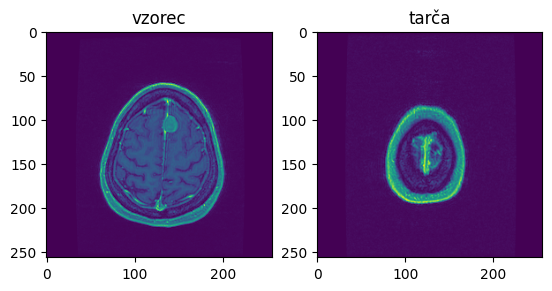

In [ ]:
import numpy as np
import itk
import matplotlib.pyplot as plt
target_path = "RegLib_C01_1.nrrd"
source_path = "RegLib_C01_2.nrrd"

target_itk = itk.imread(target_path)
target_meta = dict(target_itk)
target = np.asarray(target_itk)
print(f"Target shape: {target.shape}")
print(f"Target spacing: {target_meta['spacing']}")
print(f"Target direction: {target_meta['direction']}")

source_itk = itk.imread(source_path)
source_meta = dict(source_itk)
source = np.asarray(source_itk)
print(f"Source shape: {source.shape}")
print(f"Source spacing: {source_meta['spacing']}")
print(f"Source direction: {source_meta['direction']}")

# Check whether the orientation of the images are the same.
assert np.array_equal(dict(target_itk)["direction"], dict(source_itk)["direction"]), "The orientation of source and target images need to be the same."

fig, axes = plt.subplots(1,2)
axes[0].imshow(source[100])
axes[0].set_title('vzorec')
axes[1].imshow(target[100])
axes[1].set_title('tarča')
plt.show()


# Run Inference with uniGradICON


Processing images

In [ ]:
# Processing images
import torch
import torch.nn.functional as F
def preprocess(img, type="ct"):
  if type == "ct":
    clamp = [-1000, 1000]
    img = (torch.clamp(img, clamp[0], clamp[1]) - clamp[0])/(clamp[1]-clamp[0])
    return F.interpolate(img, [175, 175, 175], mode="trilinear", align_corners=False)
  elif type == "mri":
    im_min, im_max = torch.min(img), torch.quantile(img.view(-1), 0.99)
    img = torch.clip(img, im_min, im_max)
    img = (img-im_min) / (im_max-im_min)
    return F.interpolate(img, [175, 175, 175], mode="trilinear", align_corners=False)
  else:
    print(f"Error: Do not support the type {type}")
    return img

target = preprocess(torch.Tensor(np.array(target)).unsqueeze(0).unsqueeze(0), type="mri")
source = preprocess(torch.Tensor(np.array(source)).unsqueeze(0).unsqueeze(0), type="mri")

Load uniGradICON

In [ ]:
from unigradicon import get_unigradicon
net = get_unigradicon()
net.cuda()
net.eval()
print()

Run infercen. To be noted, there is no instance optimization in this demo.


In [ ]:
with torch.no_grad():
  net(source.cuda(), target.cuda())

# Visualization of the registration result.


In [ ]:
def show_as_grid_contour(ax, phi, linewidth=1, stride=8, flip=False):
    data_size = phi.size()[1:]
    plot_phi = phi.cpu() - 0.5
    N = plot_phi.size()[-1]
    ax.contour(plot_phi[1], np.linspace(0, N, int(N/stride)), linewidths=linewidth, alpha=0.8)
    ax.contour(plot_phi[0], np.linspace(0, N, int(N/stride)), linewidths=linewidth, alpha=0.8)
    if flip:
        ax.set_ylim([0, data_size[0]])

def show_pair(source, target, warped, phi, axes, idx, flip=False):
    phi_scaled = phi * (torch.tensor((175, 175, 175), dtype=torch.float32).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)-1)
    if flip:
        origin = 'lower'
    else:
        origin = 'upper'
    axes[0].imshow(source.cpu()[0,0,idx], cmap="gray", origin=origin)
    axes[1].imshow(target.cpu()[0,0,idx], cmap="gray", origin=origin)
    axes[2].imshow(warped.cpu()[0,0,idx], cmap="gray", origin=origin)
    axes[3].imshow(target.cpu()[0,0,idx], cmap="gray", origin=origin)
    show_as_grid_contour(axes[3], phi_scaled[0, [1,2], idx], linewidth=0.6, stride=4, flip=flip)
    axes[4].imshow(target.cpu()[0,0,idx]-source.cpu()[0,0,idx], origin=origin)
    axes[5].imshow(target.cpu()[0,0,idx]-warped.cpu()[0,0,idx], origin=origin)

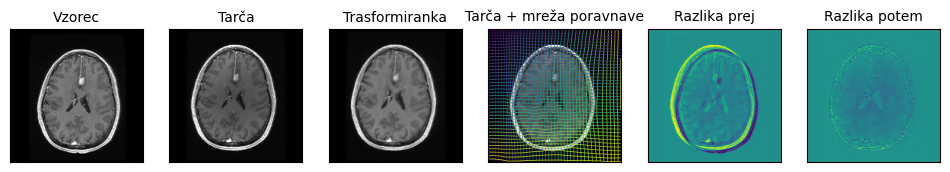

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(12,2))
show_pair(source, target, net.warped_image_A, net.phi_AB_vectorfield.cpu(), axes, 100)

font_size = 10
axes[0].set_title('Vzorec', fontsize=font_size)
axes[1].set_title('Tarča', fontsize=font_size)
axes[2].set_title('Trasformiranka', fontsize=font_size)
axes[3].set_title('Tarča + mreža poravnave', fontsize=font_size)
axes[4].set_title('Razlika prej', fontsize=font_size)
axes[5].set_title('Razlika potem', fontsize=font_size)
for axe in axes:
  axe.set_xticks([])
  axe.set_yticks([])
plt.show()